<a href="https://colab.research.google.com/github/RahulNaidu710/datasciencecoursera/blob/master/Kaggle_catsvsdogssimple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import random
import shutil
from shutil import copyfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import pickle
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
!unrar x "/content/drive/My Drive/cats-vs-dogs.rar" "/tmp"

In [4]:
base_dir = '/tmp/cats-vs-dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'Cat')
train_dogs_dir = os.path.join(train_dir, 'Dog')
test_unknown_dir = os.path.join(test_dir, 'unknown')

In [5]:
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
train_cats_fnames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or -1))
train_dogs_fnames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or -1))
test_fnames = os.listdir(test_unknown_dir)
test_fnames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)) or -1))
print(train_cats_fnames[:10])
print(train_dogs_fnames[:10])
print(test_fnames[:10])

['Thumbs.db', '0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']
['Thumbs.db', '0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']
['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']


In [6]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))
print('total test set images :', len(os.listdir(test_unknown_dir)))

total training cat images : 12501
total training dog images : 12501
total test set images : 12500


In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0 # Index for iterating over images

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cats_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dogs_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
try:
    os.makedirs('/tmp/cats-vs-dogs/training/Cat')
    os.makedirs('/tmp/cats-vs-dogs/training/Dog')
    os.makedirs('/tmp/cats-vs-dogs/validation/Cat')
    os.makedirs('/tmp/cats-vs-dogs/validation/Dog')
except OSError:
    pass

In [8]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + ' is of 0 length, so ignoring it')
    
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)
        
CAT_SOURCE_DIR = "/tmp/cats-vs-dogs/train/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-vs-dogs/training/Cat/"
TESTING_CATS_DIR = "/tmp/cats-vs-dogs/validation/Cat/"
DOG_SOURCE_DIR = "/tmp/cats-vs-dogs/train/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-vs-dogs/training/Dog/"
TESTING_DOGS_DIR = "/tmp/cats-vs-dogs/validation/Dog/"

In [9]:
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is of 0 length, so ignoring it
11702.jpg is of 0 length, so ignoring it


In [10]:
print(len(os.listdir('/tmp/cats-vs-dogs/training/Cat/')))
print(len(os.listdir('/tmp/cats-vs-dogs/training/Dog/')))
print(len(os.listdir('/tmp/cats-vs-dogs/validation/Cat/')))
print(len(os.listdir('/tmp/cats-vs-dogs/validation/Dog/')))

11250
11250
1250
1250


In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [11]:
#Transfer Learning
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-06-16 20:10:09--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  77.9MB/s    in 1.1s    

2020-06-16 20:10:10 (77.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [12]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [14]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x)

In [15]:
model.compile(optimizer = 'adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [16]:
train_datagen = ImageDataGenerator(rescale = 1.0/255., rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
validation_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

training_dir = '/tmp/cats-vs-dogs/training'
validation_dir = '/tmp/cats-vs-dogs/validation'
test_dir = '/tmp/cats-vs-dogs/test'

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (150, 150))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size = 20,
                                                  class_mode = None,
                                                  target_size = (150, 150),
                                                  shuffle = False)


Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [17]:
history = model.fit(train_generator,
                              validation_data = validation_generator,
                              steps_per_epoch = 22500//20,
                              epochs = 3,
                              validation_steps = 2500//20
                              )

Epoch 1/3
 951/1125 [========================>.....] - ETA: 26s - loss: 0.2538 - accuracy: 0.9141

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1125/1125 [==============================] - 182s 162ms/step - loss: 0.2402 - accuracy: 0.9161 - val_loss: 0.0980 - val_accuracy: 0.9616
Epoch 2/3
1125/1125 [==============================] - 183s 162ms/step - loss: 0.1578 - accuracy: 0.9363 - val_loss: 0.0842 - val_accuracy: 0.9668
Epoch 3/3
1125/1125 [==============================] - 183s 163ms/step - loss: 0.1479 - accuracy: 0.9398 - val_loss: 0.0903 - val_accuracy: 0.9628


In [ ]:
model.save('model_aug_adam_50ep.h5')
#from tensorflow.keras.models import load_model
#model = load_model('/model_aug_lr001_20ep.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

Text(0.5, 1.0, 'Training and validation loss')

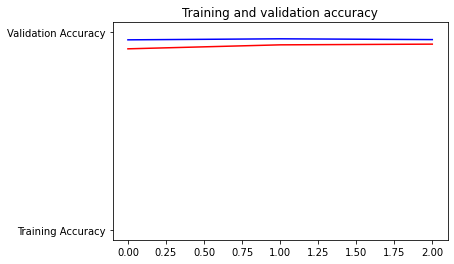

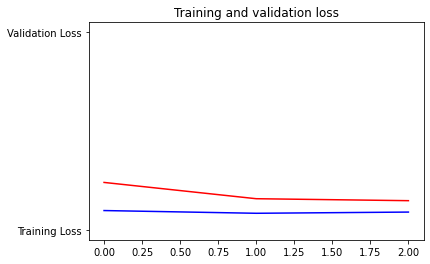

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')

In [19]:
preds = model.predict(test_generator)
print(preds[:5])

[[0.9996377]
 [1.       ]
 [0.9999738]
 [0.9640382]
 [0.010347 ]]


In [20]:
submission = pd.DataFrame(preds)
submission = submission.rename(columns = {0: 'label'})
submission = submission.reset_index()
submission = submission.rename(columns = {'index': 'id'})
submission['id'] = submission.index + 1
submission.to_csv('q.csv', index = False)

In [24]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 5.jpg to 5.jpg
[0.]
5.jpg is a cat
